In [21]:
import pandas as pd
import os
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [22]:
def merge_csv_files(directory):
    # Get list of all CSV files in the directory
    csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

    # Initialize an empty DataFrame
    merged_df = pd.DataFrame()

    # Loop through each CSV file and merge its contents into the DataFrame
    for file in csv_files:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(os.path.join(directory, file))

        # Add a 'Packet_Type' column based on the filename
        packet_type = file.split('_')[0]  # Extract packet type from filename
        df['Packet_Type'] = packet_type

        # Merge the DataFrame with the existing merged DataFrame
        merged_df = pd.concat([merged_df, df], ignore_index=True)

    # Reorder the columns to have 'Packet_Type' as the first column
    columns = ['Packet_Type'] + [col for col in merged_df.columns if col != 'Packet_Type']
    merged_df = merged_df[columns]

    return merged_df

# Example usage:
directory = "Processed Training Data"
train_df = merge_csv_files(directory)
print(train_df.shape)


directory = "Processed New Data"
new_df = merge_csv_files(directory)
print(new_df.shape)

split_index = train_df.shape[0]

# Merge the DataFrames vertically
final_df = pd.concat([train_df, new_df])
print(final_df.shape)

final_df.to_csv('final_dataset.csv', index=False)

(3220, 24)
(39, 24)
(3259, 24)


In [23]:
#Data Preprocessing
# Load the merged DataFrame
final_df = pd.read_csv("final_dataset.csv")

# Replace null values with -1
final_df.fillna(-1, inplace=True)

# Map labels to integers
label_mapping = {
    'normal': 0,
    'host scan': 1,
    'port scan': 2,
    'os scan': 3
}

# Apply mapping to the 'label' column
final_df['label'] = final_df['label'].map(label_mapping)
ml_final_df = final_df.copy()
dl_final_df = final_df.copy()

# Define categorical columns to encode
columns_to_encode = ['Packet_Type']



In [24]:
# Apply one-hot encoding to categorical columns
ml_encoder = OneHotEncoder(drop='first')
ml_encoded_columns = pd.DataFrame(ml_encoder.fit_transform(ml_final_df[columns_to_encode]).toarray(), columns=ml_encoder.get_feature_names_out(columns_to_encode))

# Drop original categorical columns from the dataframe
ml_final_df.drop(columns=columns_to_encode, inplace=True)

# Concatenate the encoded columns with the original dataframe
ml_final_df = pd.concat([ml_final_df, ml_encoded_columns], axis=1)

# Separate features (X) and target (y)
X_ml = ml_final_df.drop(columns=['label', 'Src_IP', 'Dst_IP', 'Timestamp', 'ID', 'Avg_Window', 'QD', 'S', 'R', 'P', 'A', 'U'])
y_ml = ml_final_df['label']
X_new_ml = X_ml[split_index:]
X_ml = X_ml[:split_index]
y_ml = y_ml[:split_index]
print(X_ml.columns)

# Split the data into training and testing sets
X_ml_train, X_ml_test, y_ml_train, y_ml_test = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42)

Index(['Count', 'QDCount', 'ANCount', 'TTL', 'QueryType', 'Type', 'Code',
       'Payload_Length', 'Src_Ports', 'Dst_Ports', 'F', 'Packet_Type_DNS',
       'Packet_Type_ICMP', 'Packet_Type_TCP'],
      dtype='object')


In [25]:
dl_encoder = LabelEncoder()
#dl_final_df['Packet_Type'] = dl_encoder.fit_transform(dl_final_df['Packet_Type'])
print(dl_final_df.columns)
for column in columns_to_encode:
    dl_final_df[column] = dl_encoder.fit_transform(dl_final_df[column])

# Separate features (X) and target (y)
X_dl = dl_final_df.drop(columns=['label', 'Src_IP', 'Dst_IP', 'Timestamp', 'ID', 'Avg_Window', 'QD', 'S', 'R', 'P', 'A', 'U'])
y_dl = dl_final_df['label']
X_new_dl = X_dl[split_index:]
X_dl = X_dl[:split_index]
y_dl = y_dl[:split_index]
print(X_dl.columns)

# Split the data into training and testing sets
X_dl_train, X_dl_test, y_dl_train, y_dl_test = train_test_split(X_dl, y_dl, test_size=0.2, random_state=42)

Index(['Packet_Type', 'Timestamp', 'Src_IP', 'Count', 'label', 'ID', 'QDCount',
       'ANCount', 'QD', 'TTL', 'QueryType', 'Dst_IP', 'Type', 'Code',
       'Payload_Length', 'Src_Ports', 'Dst_Ports', 'F', 'S', 'R', 'P', 'A',
       'U', 'Avg_Window'],
      dtype='object')
Index(['Packet_Type', 'Count', 'QDCount', 'ANCount', 'TTL', 'QueryType',
       'Type', 'Code', 'Payload_Length', 'Src_Ports', 'Dst_Ports', 'F'],
      dtype='object')


Accuracy: 0.9782608695652174


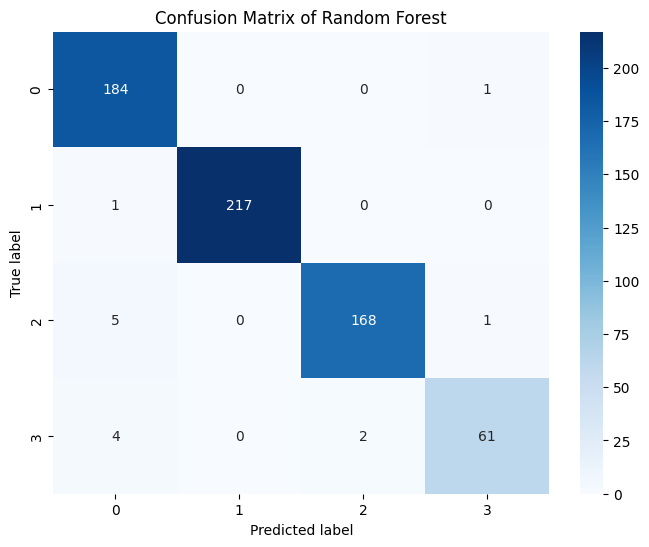

In [26]:
# Create a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf.fit(X_ml_train, y_ml_train)

# Predict on the test set
y_rf_pred = rf.predict(X_ml_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_ml_test, y_rf_pred)
print("Accuracy:", accuracy_rf)
labels = [0,1,2,3]
cm = confusion_matrix(y_ml_test, y_rf_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix of Random Forest')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


Accuracy: 0.9736024844720497


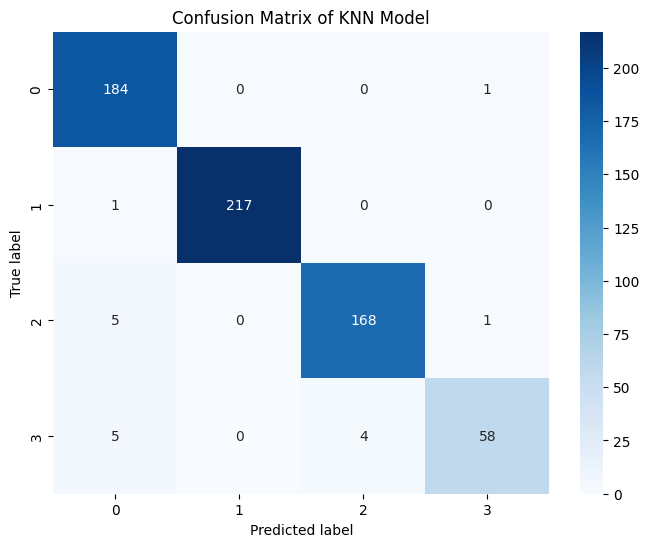

In [27]:
# Create a KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn.fit(X_ml_train, y_ml_train)

# Predict on the test set
y_knn_pred = knn.predict(X_ml_test)

# Calculate accuracy
accuracy_knn = accuracy_score(y_ml_test, y_knn_pred)
print("Accuracy:", accuracy_knn)

labels = [0,1,2,3]
cm = confusion_matrix(y_dl_test, y_knn_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix of KNN Model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Epoch 1/10


c:\Users\jeffr\anaconda3\envs\IN6232\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5004 - loss: 10.1551 - val_accuracy: 0.8779 - val_loss: 1.4813
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8681 - loss: 0.6000 - val_accuracy: 0.9089 - val_loss: 0.4796
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9167 - loss: 0.4883 - val_accuracy: 0.8992 - val_loss: 0.3358
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9171 - loss: 0.3516 - val_accuracy: 0.9244 - val_loss: 0.3303
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9150 - loss: 0.4362 - val_accuracy: 0.9302 - val_loss: 0.2439
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9133 - loss: 0.3423 - val_accuracy: 0.9438 - val_loss: 0.3433
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9381 - loss: 0.3152 - val_accuracy: 0.9535 - val_loss: 0.3086
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9239 - loss: 0.3538 - val_accuracy: 0.9535 - val_loss: 0.3330
Ep

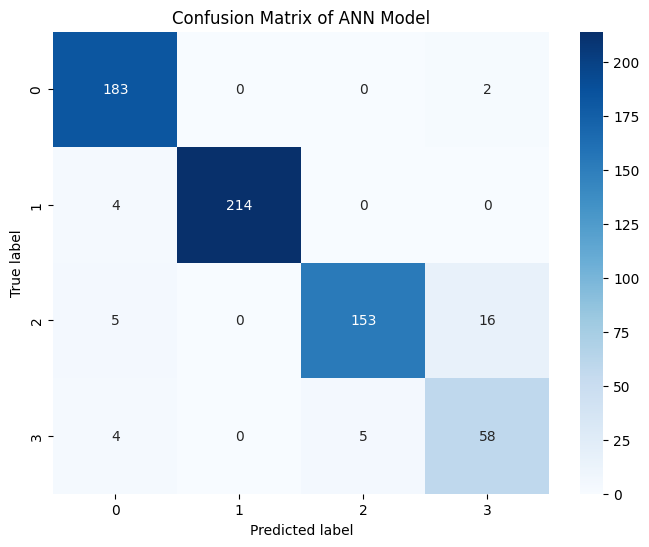

In [28]:
# Create the ANN model
model = Sequential()
model.add(Dense(64, input_shape=(X_dl_train.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))  # 4 output neurons for 4 classes with softmax activation

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_dl_train, y_dl_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy_ann = model.evaluate(X_dl_test, y_dl_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy_ann)
y_ann_pred = model.predict(X_dl_test).argmax(axis=1)

labels = [0,1,2,3]
cm = confusion_matrix(y_dl_test, y_ann_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix of ANN Model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Accuracy of the majority voted labels 0.9704968944099379


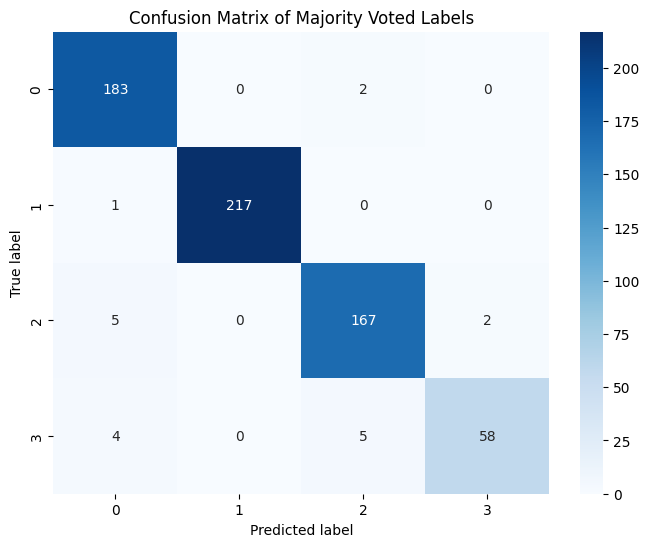

In [29]:
# Weighted voting based on accuracies
weighted_votes = (accuracy_rf * y_rf_pred + accuracy_ann * y_ann_pred + accuracy_knn * y_knn_pred) / (accuracy_rf + accuracy_ann + accuracy_knn)

# Convert the weighted votes to predicted labels
final_labels_train = np.round(weighted_votes).astype(int)

print("Accuracy of the majority voted labels", accuracy_score(y_ml_test, final_labels_train))

labels = [0,1,2,3]
cm = confusion_matrix(y_ml_test, final_labels_train)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix of Majority Voted Labels')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [30]:
# Predict labels for the new data
rf_predicted_labels = rf.predict(X_new_ml)
knn_predicted_labels = knn.predict(X_new_ml)
ann_predicted_labels = model.predict(X_new_dl)

# Add the predicted labels to the new dataset
y_new_rf = rf_predicted_labels
y_new_ann = ann_predicted_labels.argmax(axis=1)
y_new_knn = knn_predicted_labels

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [31]:

# Weighted voting based on accuracies
weighted_votes = (accuracy_rf * y_new_rf + accuracy_ann * y_new_ann + accuracy_knn * y_new_knn) / (accuracy_rf + accuracy_ann + accuracy_knn)

# Convert the weighted votes to predicted labels
final_labels = np.round(weighted_votes).astype(int)

print("Final labels:", final_labels)

Final labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2
 3 3]


In [32]:
# Get unique labels and their counts
unique_labels, label_counts = np.unique(final_labels, return_counts=True)

label_count={0:0, 1:0, 2:0, 3:0}

# Print the counts of each unique label
for label, count in zip(unique_labels, label_counts):
    label_count[label] = count

print(label_count)

{0: 0, 1: 15, 2: 1, 3: 23}


In [33]:
label_pcap = 'Normal Activity'

if label_count[1] >= 2:
    label_pcap = 'Host Scanning Activity'

if label_count[2] >= 2:
    label_pcap = 'Port Scanning Activity'

if label_count[3] >=4:
    label_pcap = 'OS Scanning Activity'

print("The given pcap data is predicted to be a", label_pcap)


The given pcap data is predicted to be a OS Scanning Activity
